## Titanic: Machine Learning from Disaster

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

We have structured the notebook in an intuitive way to the predictive modeling problem. We check existing features, only to add new features and some Machine Learning Concepts in data modelling.

### Contents of the Notebook <a class="anchor" id="toc"></a>

* [Exploratory Data Analysis](#f1)
    * [Gender vs Survival](#f1.1)
    * [Passenger Classes vs Survival](#f1.3)
    * [Initials vs Survival](#f1.4)
    * [Group/Family vs Survival](#f1.5)
    * [Fare vs Survival](#f1.6)
    * [Embarked vs Survival](#f1.7)
 
* [Handling Missing Values](#f2)
    * [Embarked:Missing Value](#f2.1)
    * [Age:Missing Value](#f2.2)
    * [Cabin:Missing Value](#f2.3)
    * [Fare:Missing Value](#f2.4)
* [Feature Engineering](#f3)

# Exploratory Data Analysis <a class="anchor" id="f1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

path = './input/'

data = pd.read_csv(path + 'train.csv')
data.shape

(891, 12)

In [2]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


[Table of Contents](#toc)

## Gender vs Survival <a class="anchor" id="f1.1"></a>

In order to know if the gender of a person played an important role in the improving their survival rate, we plot the Survival vs Gender. 

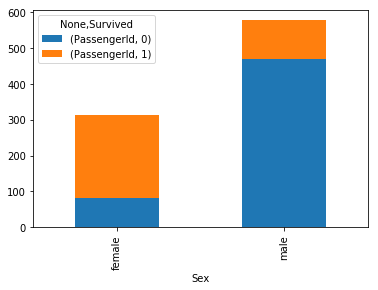

In [3]:
data[['PassengerId','Survived','Sex']].groupby(['Sex', 'Survived']).count().unstack().plot(kind='bar', stacked=True)

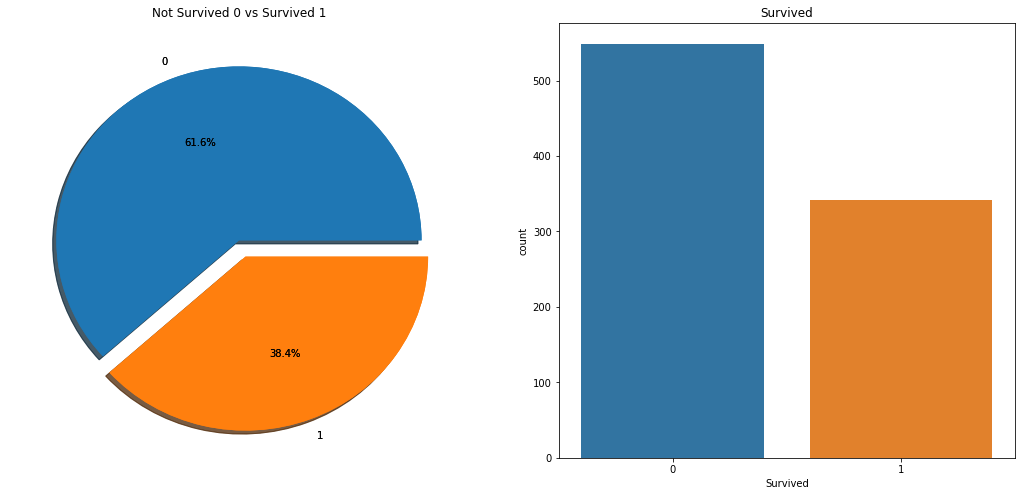

In [4]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
labels = ['Not Survived', 'Survived']
sizes = list(data['Survived'].value_counts())
explode = (0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
data['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Not Survived 0 vs Survived 1')
ax[0].set_ylabel('')

sns.countplot('Survived',data=data,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

In totality, we can see that the persons' gender does play a crucial role. Most females survived while most males died.
We have to dig further to know the survival rate distribution.

[Table of Contents](#toc)

## Passenger Classes vs Survival <a class="anchor" id="f1.3"></a>

We need to know the exact population distribution across the different passenger classes, to see whether the passengers belonging to a particular class had a higher chance of surviving the fateful accident. 

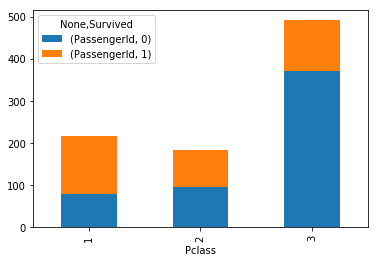

In [5]:
data[['PassengerId','Survived','Pclass']].groupby(['Pclass', 'Survived']).count().unstack().plot(kind='bar', stacked=True)

In [6]:
pd.crosstab(data.Pclass,data.Survived,margins=True)

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


/home/rym/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/rym/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


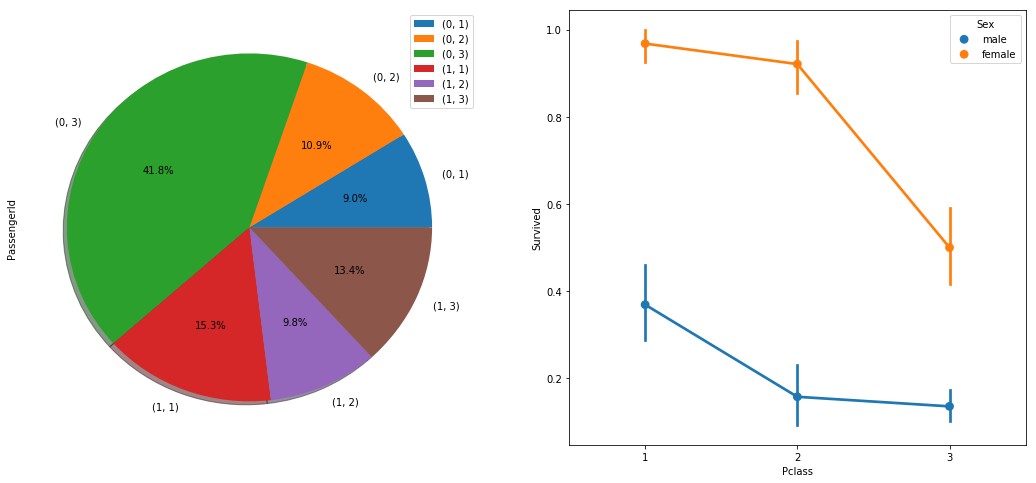

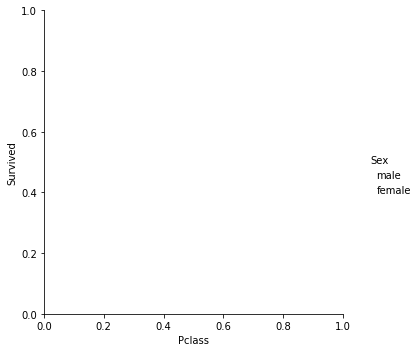

In [7]:
df=data[['PassengerId','Survived','Pclass']].groupby(['Survived','Pclass']).count()
f,ax=plt.subplots(1,2,figsize=(18,8))
df.plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True,subplots=True)

sns.factorplot('Pclass','Survived',hue='Sex',data=data,ax=ax[1])
plt.show()

The pie chart shows that people belonging to Passenger class 3 did not survive, i.e more than two thirds of those that died belonged to Passenger Class 3.

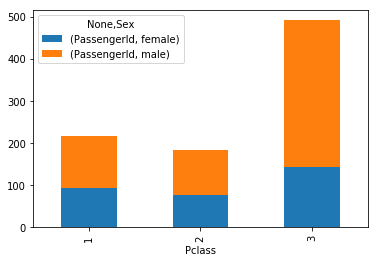

In [8]:
data[['PassengerId','Sex','Pclass']].groupby(['Pclass', 'Sex']).count().unstack().plot(kind='bar', stacked=True)

More females in higher classes (1 and 2). What can we conclude? 
Did females survive more because they were wealthy?
Did wealthier people survive more because they had a high ratio of females?

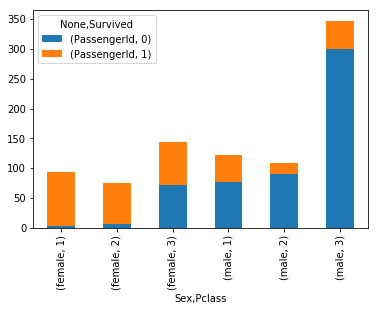

In [9]:
data[['PassengerId','Survived','Sex','Pclass']].groupby(['Sex', 'Pclass', 'Survived']).count().unstack().plot(kind='bar', stacked=True)

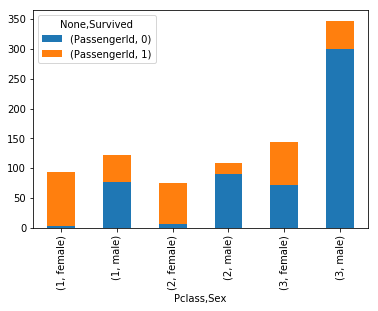

In [10]:
data[['PassengerId','Survived','Sex','Pclass']].groupby(['Pclass', 'Sex', 'Survived']).count().unstack().plot(kind='bar', stacked=True)

Both Class and gender seem to affect the survival rate, so both features should be used.

[Table of Contents](#toc)

## Initials vs Survival <a class="anchor" id="f1.4"></a>

We use the initials such as Col/Dr/Mme, etc. to understand the person's respectability in the society as subsequently, their survival characteristics.

In [11]:
data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.')

In [12]:
pd.crosstab([data.Initial,data.Sex],[data.Survived])

Survived           0    1
Initial  Sex             
Capt     male      1    0
Col      male      1    1
Countess female    0    1
Don      male      1    0
Dr       female    0    1
         male      4    2
Jonkheer male      1    0
Lady     female    0    1
Major    male      1    1
Master   male     17   23
Miss     female   55  127
Mlle     female    0    2
Mme      female    0    1
Mr       male    436   81
Mrs      female   26   99
Ms       female    0    1
Rev      male      6    0
Sir      male      0    1

We can see that married women (Mrs), small children(Miss/Master) had higher survival rate as compared to the rest. Also,the nobility, despite being outnumbered, did get a chance to survive.

[Table of Contents](#toc)

## Group/Family vs Survival <a class="anchor" id="f1.5"></a>

Let's see if big families tend to survive more or less, or if it doesn't affect the survival.
Maybe families were given priority, or maybe having too many family members hindered the survival.

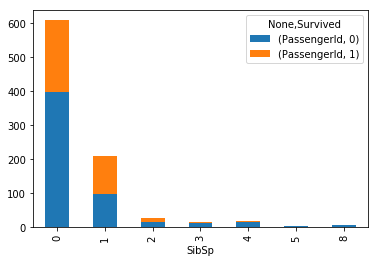

In [13]:
df_sibsp = data[['PassengerId','Survived','SibSp']].groupby(['SibSp', 'Survived']).count()
df_sibsp.unstack().plot(kind='bar', stacked=True)

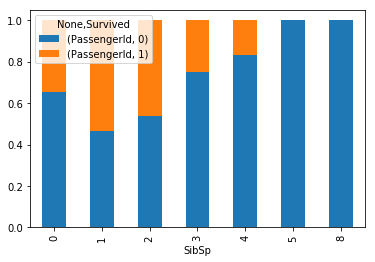

In [14]:
def ratio(df, both = [], only_0 = [], only_1 = []):
    df.loc[:,'PassengerId'] = df.loc[:, 'PassengerId'].astype(float)
    for i in both:
        total = df.loc[(i,0),] + df.loc[(i,1),]
        df.loc[(i,0),] = df.loc[(i,0),]/total
        df.loc[(i,1),] = df.loc[(i,1),]/total
        total = 0
    for j in only_0:
        df.loc[(j,0),] = 1
    for k in only_1:
        df.loc[(j,1),] = 1
    return df

ratio(df_sibsp, range(5), [5,8]).unstack().plot(kind='bar', stacked=True)

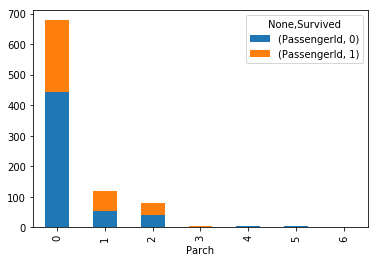

In [15]:
df_parch = data[['PassengerId','Survived','Parch']].groupby(['Parch', 'Survived']).count()
df_parch.unstack().plot(kind='bar', stacked=True)

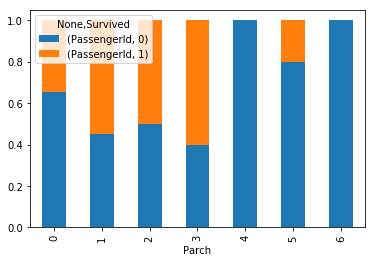

In [16]:
ratio(df_parch, [0,1,2,3,5], [4,6]).unstack().plot(kind='bar', stacked=True)

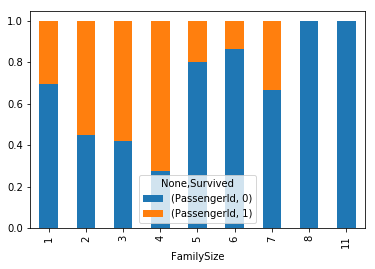

In [17]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
df_famsize = data[['PassengerId','Survived','FamilySize']].groupby(['FamilySize', 'Survived']).count()
ratio(df_famsize, range(1,8), [8,11]).unstack().plot(kind='bar', stacked=True)

- We notice that small families have a higher survival rate, while people who are alone or in a big family have a lower survival rate.

Thus, it'd be more interesting to replace the quantitative FamilySize by a categorical variable which we will call Size.

See part "Feature Engineering" for the new variable creation.

- There's another way to evaluate a travelling group's size, even if they're not a family.
People travelling together are more likely to have bought the ticket together.

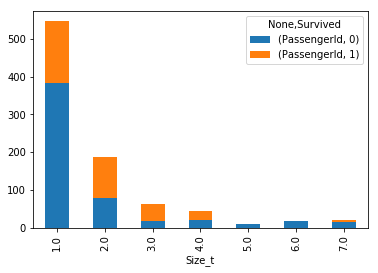

In [18]:
ticket_count = data['Ticket'].value_counts()
data_ticket = pd.DataFrame(data={'ticket' : ticket_count.index.values, 'count' : ticket_count.values})

size_t = np.zeros(data.shape[0])
for i in range(data.shape[0]):
    idx = data_ticket.index[data_ticket['ticket'] == data.loc[i, 'Ticket']].tolist()[0]
    size_t[i] = data_ticket.loc[idx, 'count']
data['Size_t'] = size_t

df_size_t = data[['PassengerId','Survived','Size_t']].groupby(['Size_t', 'Survived']).count()
df_size_t.unstack().plot(kind='bar', stacked=True)

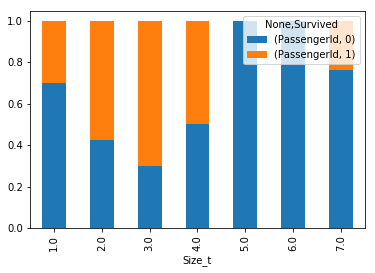

In [19]:
ratio(df_size_t, [1,2,3,4,7], [5,6]).unstack().plot(kind='bar', stacked=True)

For this feature as well, a size between 2 and 4 is linked to a bigger chance of survival.

Comparing its distribution with that of FamilySize shows us that it'd be redondant to use both features.

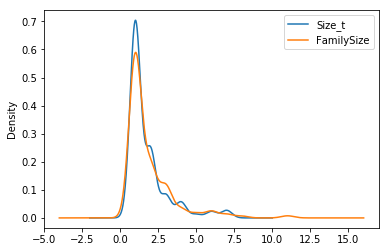

In [20]:
data.plot(x='PassengerId', y=['Size_t', 'FamilySize'], kind='density')

[Table of Contents](#toc)

## Fare vs Survival <a class="anchor" id="f1.6"></a>

There is a saying that money can buy everything. Can it buy higher survivability?

/home/rym/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


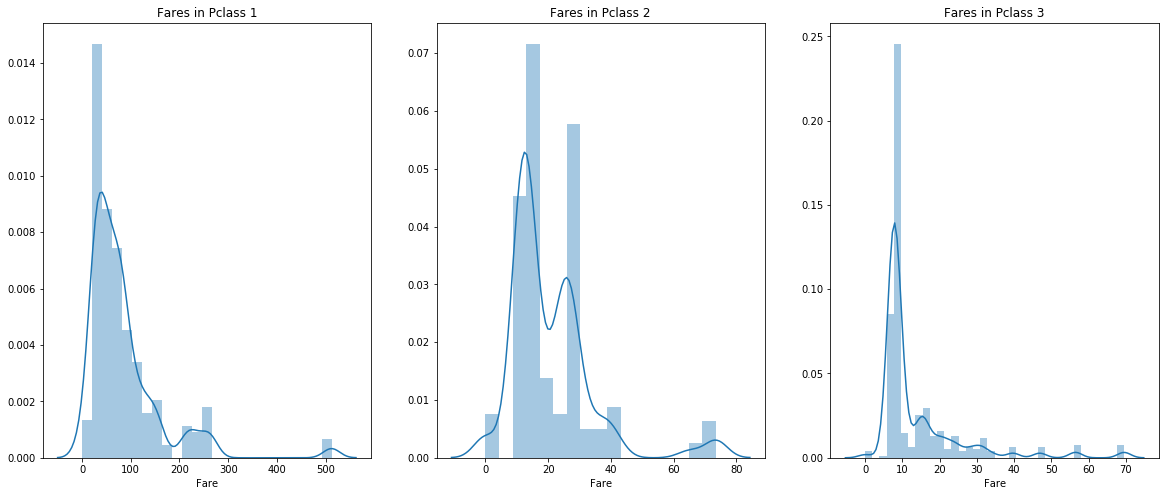

In [21]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(data[data['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(data[data['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

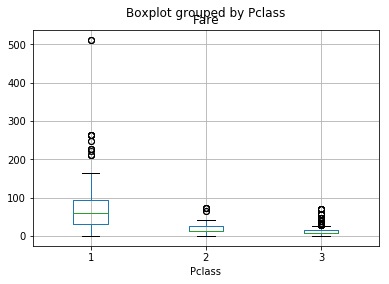

In [22]:
data.boxplot('Fare', by='Pclass')

The ticket fare seems to be highly correlated to the class.

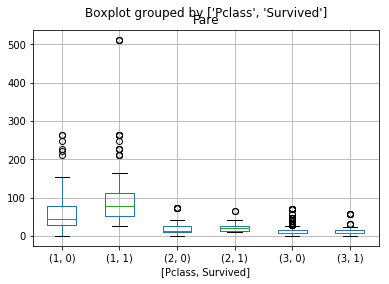

In [23]:
data.boxplot('Fare', by=['Pclass', 'Survived'])

In the same class, a difference of ticket fare only seems to affect the survival rate for class 1.
In any case, rich people are more likely to survive 

Conclusion : Keep or drop Fare/Pclass? Any new feature to extract?

[Table of Contents](#toc)

## Embarked vs Survival <a class="anchor" id="f1.7"></a>

We need to see whether there is a correlation between the boarding point and the survival chances. 

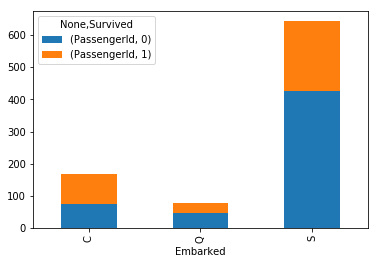

In [24]:
df_emb = data[['PassengerId','Survived','Embarked']].groupby(['Embarked', 'Survived']).count()
df_emb.unstack().plot(kind='bar', stacked=True)

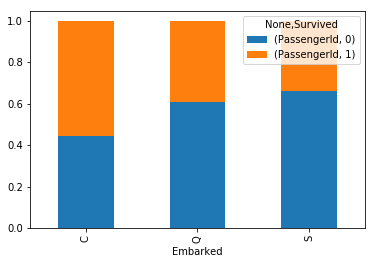

In [25]:
ratio(df_emb, ['C', 'Q', 'S']).unstack().plot(kind='bar', stacked=True)

It seems like for people who embarked at port C, the chance of survival is higher than for people who embarked at ports Q and S.

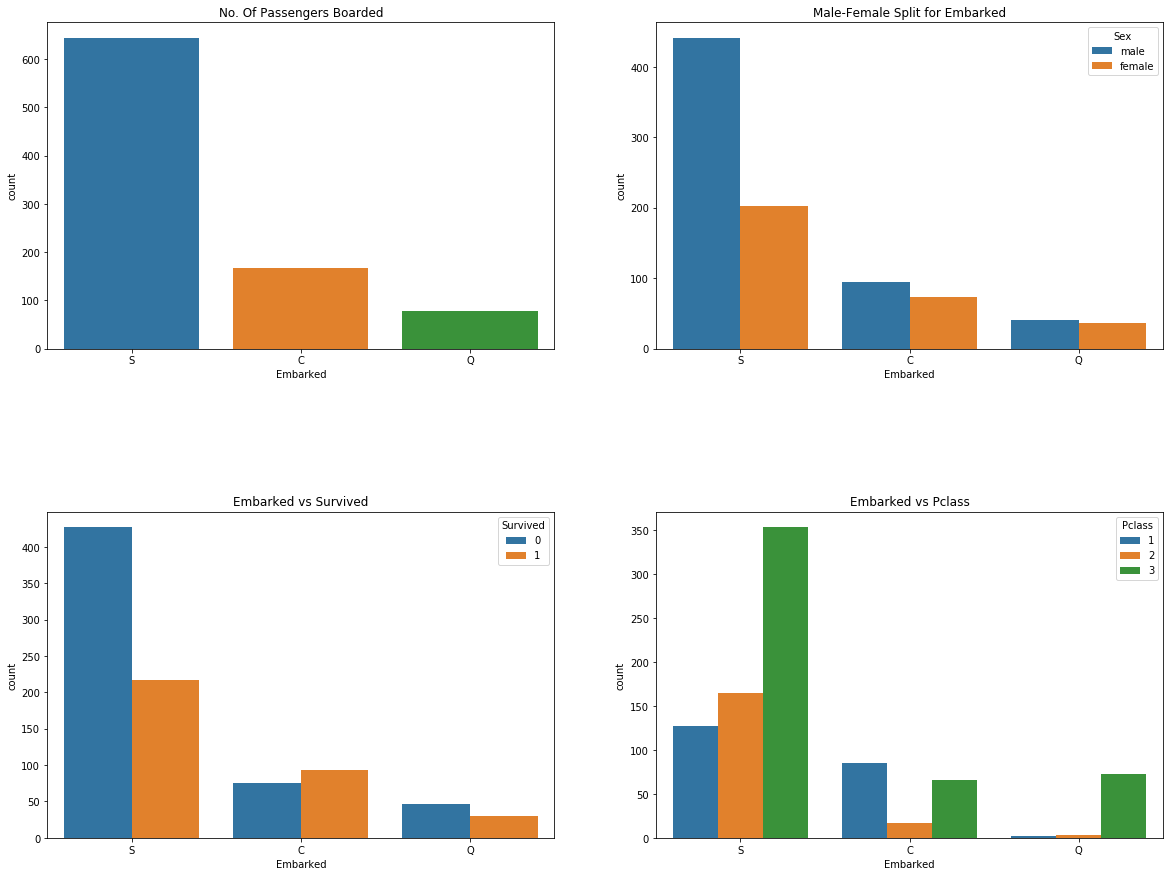

In [26]:
    f,ax=plt.subplots(2,2,figsize=(20,15))
    sns.countplot('Embarked',data=data,ax=ax[0,0])
    ax[0,0].set_title('No. Of Passengers Boarded')
    sns.countplot('Embarked',hue='Sex',data=data,ax=ax[0,1])
    ax[0,1].set_title('Male-Female Split for Embarked')
    sns.countplot('Embarked',hue='Survived',data=data,ax=ax[1,0])
    ax[1,0].set_title('Embarked vs Survived')
    sns.countplot('Embarked',hue='Pclass',data=data,ax=ax[1,1])
    ax[1,1].set_title('Embarked vs Pclass')
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    plt.show()

In [27]:
pd.crosstab([data.Embarked,data.Pclass],[data.Sex,data.Survived],margins=True)

Sex             female      male       All
Survived             0    1    0    1     
Embarked Pclass                           
C        1           1   42   25   17   85
         2           0    7    8    2   17
         3           8   15   33   10   66
Q        1           0    1    1    0    2
         2           0    2    1    0    3
         3           9   24   36    3   72
S        1           2   46   51   28  127
         2           6   61   82   15  164
         3          55   33  231   34  353
All                 81  231  468  109  889

/home/rym/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/rym/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


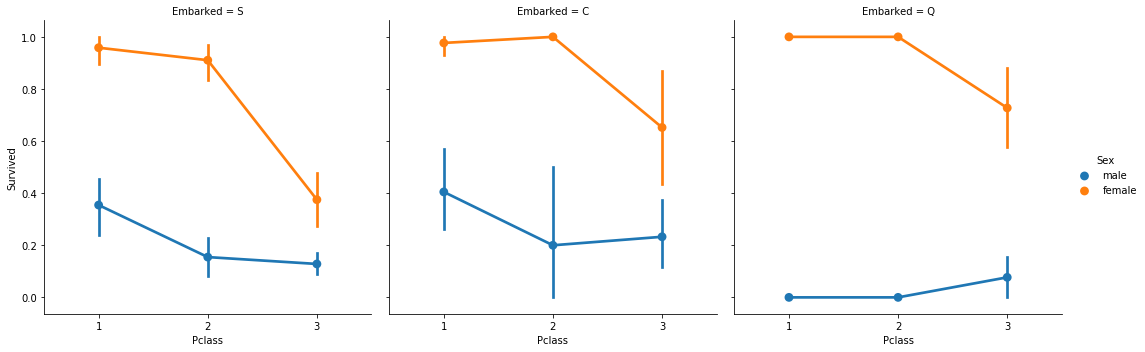

In [28]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=data)
plt.show()

[Table of Contents](#toc)

## Handling Missing Values <a class="anchor" id="f2"></a>

In [29]:
data_test = pd.read_csv(path + 'test.csv')
data_test.shape

(418, 11)

Let's see if we have any missing values in our data

In [30]:
col_na = []
nb_na = np.zeros(data.shape[1])
for i in range(data.shape[1]):
    col_na.append(data.columns[i])
    nb_na[i] = data.iloc[:,i].isna().sum()
df_na = pd.DataFrame(col_na, nb_na)
df_na

,0
0.0,PassengerId
0.0,Survived
0.0,Pclass
0.0,Name
0.0,Sex
177.0,Age
0.0,SibSp
0.0,Parch
0.0,Ticket
0.0,Fare


In [31]:
col_na = []
nb_na = np.zeros(data_test.shape[1])
for i in range(data_test.shape[1]):
    col_na.append(data_test.columns[i])
    nb_na[i] = data_test.iloc[:,i].isna().sum()
df_na = pd.DataFrame(col_na, nb_na)
df_na

,0
0.0,PassengerId
0.0,Pclass
0.0,Name
0.0,Sex
86.0,Age
0.0,SibSp
0.0,Parch
0.0,Ticket
1.0,Fare
327.0,Cabin


We need to find a way to fill Age, Cabin and Embarked

## Embarked:Missing Value <a class="anchor" id="f2.1"></a>

We use the most common boarding location to fill the missing values of Embarked column. 

If we can find another passanger with the same ticket, we can use their Embarked value to fill the NA

In [32]:
missing_emb = data.index[data['Embarked'].isna()].tolist()
ticket = np.zeros(len(missing_emb))

for i in range(len(missing_emb)):
    for j in range(data.shape[0]):
        if(j != missing_emb[i] and data.loc[j, 'Ticket'] == data.loc[missing_emb[i], 'Ticket']):
            ticket[i] = data.loc[j, 'Ticket']
ticket

array([113572., 113572.])

In [33]:
data[data['Ticket'] == '113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,FamilySize,Size_t
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss,1,2.0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs,1,2.0


No one else has the same ticket, so the second best option is probably to fill the column with the most common value

In [34]:
data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [35]:
data['Embarked'].fillna('S',inplace=True)
data_test['Embarked'].fillna('S',inplace=True)

[Table of Contents](#toc)

## Age:Missing Value <a class="anchor" id="f2.2"></a>

We use the kNN algorithm to compute the missing age values. We use Pclass, Sex, SibSp and Initials.

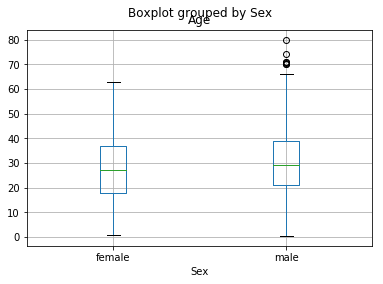

In [36]:
### To fill missing age, we can look for a relationship with other variables

data.boxplot('Age', by='Sex')

#Age is distributed differently for males and females

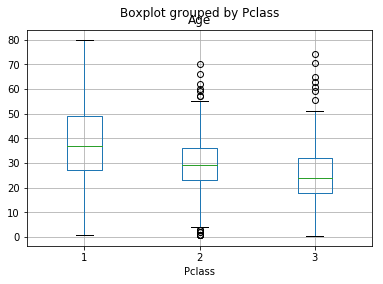

In [37]:
data.boxplot('Age', by='Pclass')

#Age is distributed even more differently depending on class

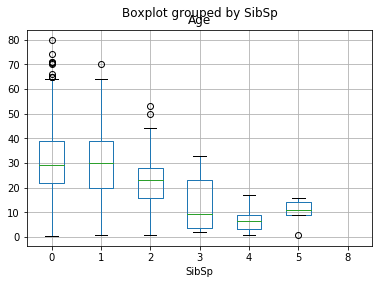

In [38]:
data.boxplot('Age', by='SibSp')

#Someone with a SibSp higher than 2 is travelling with siblings,
#it's more likely to be someone young travelling with their family

In [39]:
data['Initial']=data.Name.str.extract('([A-Za-z]+)\.')
data_test['Initial']=data_test.Name.str.extract('([A-Za-z]+)\.')

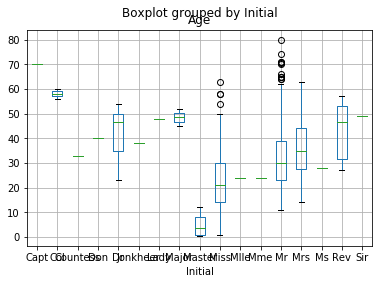

In [40]:
data.boxplot('Age', by='Initial',autorange=True)

In [41]:
result = pd.concat([data[['Initial', 'PassengerId']], data_test[['Initial', 'PassengerId']]])
result.Initial = pd.Categorical(result.Initial).codes
#result.tail()
data['Initial'] = result[:data.shape[0]]['Initial']
data_test['Initial'] = result.iloc[-data_test.shape[0]:]['Initial']

In [42]:
data.replace('male', 0, inplace=True)
data.replace('female', 1, inplace=True)
data_test.replace('male', 0, inplace=True)
data_test.replace('female', 1, inplace=True)

In [43]:
#We can try to fill the missing age values thanks to class and gender, using KNN

reg = KNeighborsRegressor(n_neighbors=3)
data_age = (data.loc[data['Age'].isna() == False]).iloc[:,[2,4,5,6,12]]
X_age = data_age[['Pclass','Sex','SibSp', 'Initial']]
y_age = data_age['Age']
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X_age, y_age, test_size=0.33)
reg.fit(X_age_train, y_age_train)
pred_age = reg.predict((data.loc[data['Age'].isna() == True]).iloc[:,[2,4,6,12]])
reg.score(X_age_test, y_age_test)

0.1810130167344648

In [44]:
i = 0
for j in range(data.shape[0]):
    if(np.isnan(data.loc[j, 'Age'])):
        data.loc[j, 'Age'] = round(pred_age[i])
        i += 1

In [45]:
pred_age_test = reg.predict((data_test.loc[data_test['Age'].isna() == True]).iloc[:,[1,3,5,11]])
k = 0
for l in range(data_test.shape[0]):
    if(np.isnan(data_test.loc[l, 'Age'])):
        data_test.loc[l, 'Age'] = round(pred_age_test[k])
        k += 1

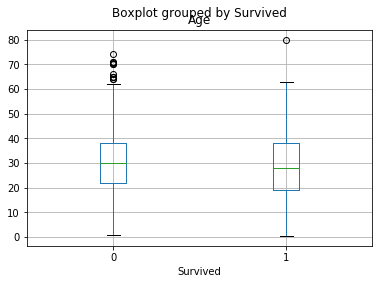

In [46]:
data.boxplot('Age', by='Survived')

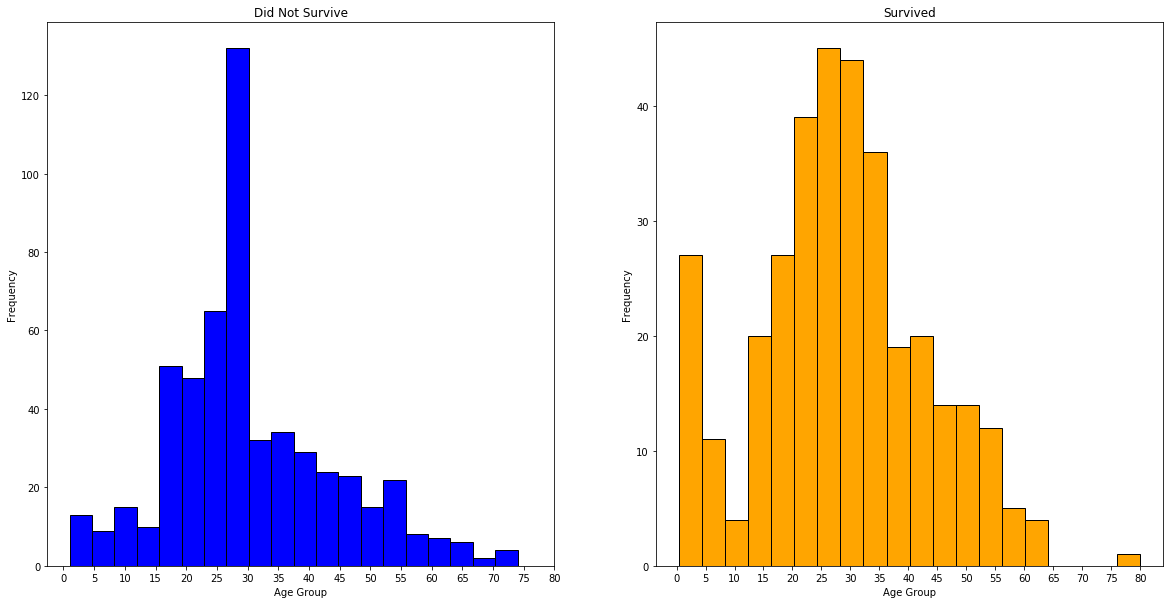

In [47]:
f,ax=plt.subplots(1,2,figsize=(20,10))
data[data['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='blue')
ax[0].set_title('Did Not Survive')
ax[0].set_xlabel('Age Group')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
data[data['Survived']==1].Age.plot.hist(ax=ax[1],color='orange',bins=20,edgecolor='black')
ax[1].set_title('Survived')
ax[1].set_xlabel('Age Group')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

To conclude, there were 3 age groups that had a higher chance of survival.
    1. Toddlers (0-5 yrs)
    2. Teenagers (15-20 yrs)
    3. Elderly (75 yrs above)
    
[Table of Contents](#toc)

## Cabin:Missing Value <a class="anchor" id="f2.3"></a>

In [48]:
### Missing values for cabin

data[['PassengerId', 'Pclass']].where(data['Cabin'].isna()).groupby(['Pclass']).count()

,PassengerId
Pclass,
1.0,40
2.0,168
3.0,479


In [49]:
data[['PassengerId', 'Pclass']].groupby(['Pclass']).count()

,PassengerId
Pclass,
1,216
2,184
3,491


Cabin seems to only be interesting for passengers of the class 1, which are a minority

In [50]:
#location = []
#for i in range(891):
#    if(isinstance(data.loc[i, 'Cabin'], str)):
#        location.append(data.loc[i, 'Cabin'][0])
#    else:
#        location.append(np.nan)
#data['Location'] = location

## Fare:Missing Value <a class="anchor" id="f2.4"></a>

In [51]:
fare = data[['Pclass','Fare']].groupby('Pclass').mean()
fare

,Fare
Pclass,
1,84.154687
2,20.662183
3,13.675550


In [52]:
missing_fare = data_test.index[data_test['Fare'].isna()]
for i in missing_fare:
    data_test.loc[i, 'Fare'] = fare.loc[data_test.loc[i, 'Pclass']][0]

[Table of Contents](#toc)

# Feature Engineering  <a class="anchor" id="f3"></a>

## Size <a class="anchor" id="f3.1"></a>

Someone travelling alone or with a big group : Size = 0
Small family (between 2 and 4 members) : Size = 1

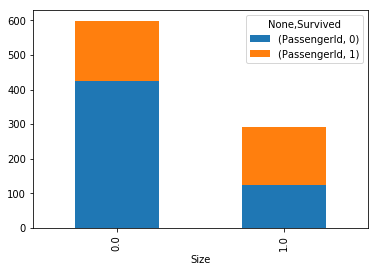

In [53]:
size = np.zeros(data.shape[0])
for i in range(data.shape[0]):
    if(data.loc[i, 'FamilySize'] > 1 and data.loc[i, 'FamilySize'] < 5):
        size[i] = 1
        
size_test = np.zeros(data_test.shape[0])
data_test['FamilySize'] = data_test['SibSp'] + data_test['Parch'] + 1
for i in range(data_test.shape[0]):
    if(data_test.loc[i, 'FamilySize'] > 1 and data_test.loc[i, 'FamilySize'] < 5):
        size_test[i] = 1
    
data['Size'] = size
data_test['Size'] = size_test

data[['PassengerId','Survived','Size']].groupby(['Size', 'Survived']).count().unstack().plot(kind='bar', stacked=True)

## Embarked:Dummy variables <a class="anchor" id="f3.2"></a>

We can replace the Embarked feature with dummy variables

In [54]:
emb = pd.get_dummies(data['Embarked'], drop_first=True)
emb_test = pd.get_dummies(data_test['Embarked'], drop_first=True)
data['Q'] = emb['Q']
data['S'] = emb['S']
data_test['Q'] = emb_test['Q']
data_test['S'] = emb_test['S']

## Farebin <a class="anchor" id="f3.3"></a>

We've made categories based on the ticket Fare

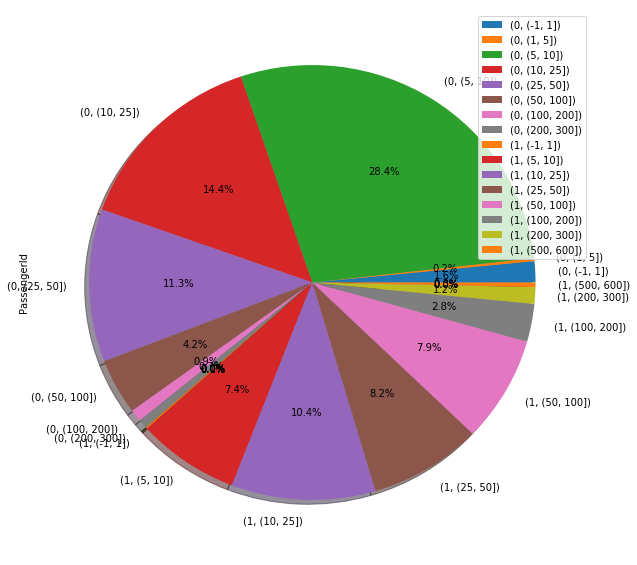

In [55]:
bins = [-1, 1, 5, 10, 25, 50, 100, 200, 300, 400, 500, 600]
data['Farebin'] = pd.cut(data['Fare'], bins)
pd.crosstab([data.Farebin,data.Sex],[data.Survived])

df=data[['PassengerId','Survived','Farebin']].groupby(['Survived','Farebin']).count()
f,ax=plt.subplots(figsize=(10,10))
patches = df.plot.pie(autopct='%1.1f%%',ax=ax,shadow=True,subplots=True)
#list(patches)

In [56]:
data_test['Farebin'] = pd.cut(data['Fare'], bins)

In [57]:
data = pd.concat([data, pd.get_dummies(data['Farebin'], drop_first=True)], axis=1)
data_test = pd.concat([data_test, pd.get_dummies(data_test['Farebin'], drop_first=True)], axis=1)

These should be the final two lines of code.
It generates a clean csv to be used for training and testing our models

In [63]:
data.iloc[:, [0, 1, 2, 4, 5, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]].to_csv('./cleanData/train.csv')
data_test.iloc[:,[0, 1, 3, 4, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]].to_csv('./cleanData/test.csv')

In [59]:
col_na = []
nb_na = np.zeros(data.shape[1])
for i in range(data.shape[1]):
    col_na.append(data.columns[i])
    nb_na[i] = data.iloc[:,i].isna().sum()
df_na = pd.DataFrame(col_na, nb_na)
df_na

,0
0.0,PassengerId
0.0,Survived
0.0,Pclass
0.0,Name
0.0,Sex
0.0,Age
0.0,SibSp
0.0,Parch
0.0,Ticket
0.0,Fare


In [60]:
col_na = []
nb_na = np.zeros(data_test.shape[1])
for i in range(data_test.shape[1]):
    col_na.append(data_test.columns[i])
    nb_na[i] = data_test.iloc[:,i].isna().sum()
df_na = pd.DataFrame(col_na, nb_na)
df_na

,0
0.0,PassengerId
0.0,Pclass
0.0,Name
0.0,Sex
0.0,Age
0.0,SibSp
0.0,Parch
0.0,Ticket
0.0,Fare
327.0,Cabin
